In [1]:
from mvnx import MVNX
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import numpy as np

In [2]:
xsense = MVNX('../CHOLE_Robot_Joystick_M-001.mvnx')

xsense_joint_angles = pd.DataFrame(xsense.jointAngle, columns=[f"{joint}_{axis}" for joint in xsense.joints.keys() for axis in ['X', 'Y', 'Z']])
xsense_joint_angles['Timecode'] = xsense.timecode
xsense_joint_angles['Time'] = xsense.time

xsense_center_of_mass = pd.DataFrame(xsense.centerOfMass, columns=[f"{unnamed}_{axis}" for unnamed in ['1','2','3','4','5','6'] for axis in ['X', 'Y', 'Z']])
xsense_center_of_mass['Timecode'] = xsense.timecode
xsense_center_of_mass['Time'] = xsense.time

vicon_rula = pd.read_csv("../comprehensive_rula_vicon.csv")
vicon_positions = pd.read_excel("../Vicon_Keypoints_Data.xlsx", sheet_name=None)


In [60]:
# some positions still misssin gdue to error [:7]
vicon_positions_dfs = []
for key in list(vicon_positions.keys())[:7]:
    df = pd.DataFrame(vicon_positions[key], columns=['X', 'Y', 'Z'])
    df['name'] = key
    df.loc[:,'Timecode_from_xsense'] = str("0")
    df.loc[:,'Timecode_from_xsense'][:len(xsense_center_of_mass['Timecode'])] = xsense_center_of_mass['Timecode'].values.astype(str)
    # !!!! remaining values must still be filled or handles appropriately
    df.loc[:,'Time'] = int(0)
    df.loc[:,'Time'][:len(xsense_center_of_mass['Time'])] = xsense_center_of_mass['Time'].values.astype(int) 
    vicon_positions_dfs.append(df)

C:\Users\gu95gif\AppData\Local\Temp\ipykernel_28008\2722020660.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.loc[:,'Timecode_from_xsense'][:len(xsense_center_of_mass['Timecode'])] = xsense_center_of_mass['Timecode'].values.astype(st

In [61]:
vicon_positions_dfs

[                 X           Y            Z  name Timecode_from_xsense  Time
 0       948.805054  808.972168  1559.997559  Neck          12:03:15:01     0
 1       948.668701  809.121582  1559.931885  Neck          12:03:15:03    17
 2       948.548767  809.255371  1559.872437  Neck          12:03:15:04    34
 3       948.445251  809.373352  1559.819336  Neck          12:03:15:04    50
 4       948.357910  809.475708  1559.772339  Neck          12:03:15:06    67
 ...            ...         ...          ...   ...                  ...   ...
 85929  1079.003906  664.109436  1537.778809  Neck                    0     0
 85930  1079.190918  664.157410  1537.687744  Neck                    0     0
 85931  1079.380371  664.208801  1537.593262  Neck                    0     0
 85932  1079.572266  664.263672  1537.495117  Neck                    0     0
 85933  1079.766846  664.321899  1537.393555  Neck                    0     0
 
 [85934 rows x 6 columns],
                  X            Y   

In [63]:
vicon_rula.head()

,Filename,ScoreA,ScoreB,GrandScore,UpperArmAngle,LowerArmAngle,WristAngle,NeckAngle,NeckTwistAngle,TrunkAngle
0,12_03_01_766.json,3,8,3,44.9226,61.79280,-1,124.3890,123.5160,-1
1,12_03_01_783.json,4,8,4,114.1330,3.77756,-1,36.4548,52.4862,-1
2,12_03_01_800.json,4,8,4,0.0000,91.74450,-1,53.5460,87.6967,-1
3,12_03_01_816.json,4,8,4,0.0000,55.37180,-1,55.0766,123.5120,-1
4,12_03_01_833.json,4,8,4,0.0000,52.31590,-1,126.4560,127.5160,-1


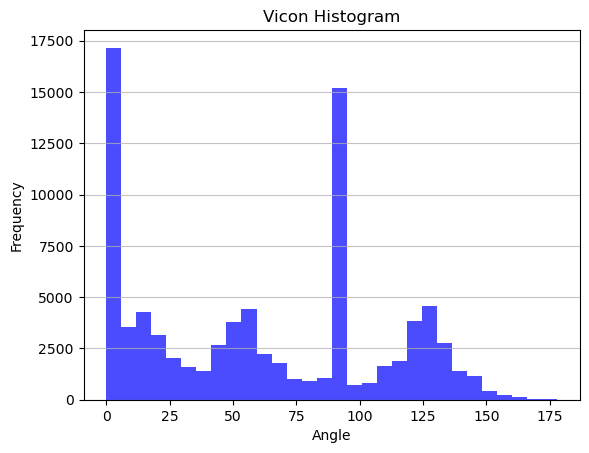

In [64]:
plt.hist(vicon_rula.LowerArmAngle, bins=30, color='blue', alpha=0.7)
plt.title('Vicon Histogram')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

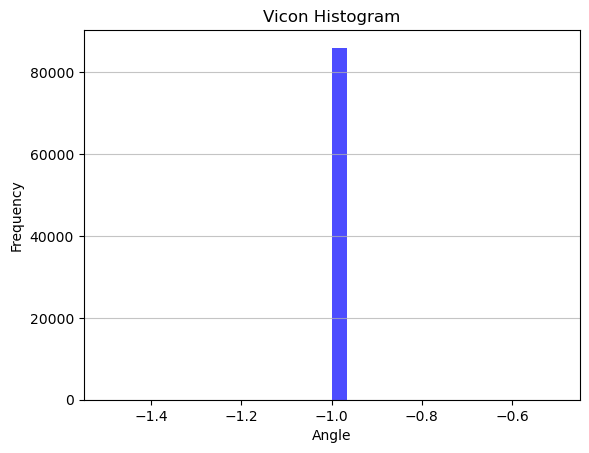

In [65]:
plt.hist(vicon_rula.TrunkAngle, bins=30, color='blue', alpha=0.7)
plt.title('Vicon Histogram')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()